In [1]:
import os

file_paths = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_paths.append(os.path.join(dirname, filename))

print(f"Total files: {len(file_paths)}")
print("Example files:", file_paths[:5])


Total files: 21418
Example files: ['/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv', '/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json', '/kaggle/input/cassava-leaf-disease-classification/train.csv', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train14-1338.tfrec', '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train13-1338.tfrec']


In [2]:
import pandas as pd
import numpy as np
import json


with open('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    label_map = json.load(f)

print("Label Mapping:", label_map)

df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')
print(df.head())


Label Mapping: {'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}
         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3


In [3]:
df['image_path'] = df['image_id'].apply(lambda x: os.path.join( '/kaggle/input/cassava-leaf-disease-classification/train_images', x))
df['label_str'] = df['label'].apply(lambda x: label_map[str(x)])

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(df['image_path'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def process_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(process_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

2025-05-20 09:35:02.812851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747733703.096469      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747733703.180342      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 09:35:23.069105: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics =['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,405 (431.27 KB)

 Trainable params: 110,405 (431.27 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS
)


Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1140s 2s/step - accuracy: 0.6065 - loss: 1.1794 - val_accuracy: 0.6203 - val_loss: 1.0837
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1164s 2s/step - accuracy: 0.6261 - loss: 1.0658 - val_accuracy: 0.6379 - val_loss: 0.9993
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - accuracy: 0.6357 - loss: 1.0018 - val_accuracy: 0.6325 - val_loss: 1.0251
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1266s 2s/step - accuracy: 0.6470 - loss: 0.9510 - val_accuracy: 0.6638 - val_loss: 0.9238
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1167s 2s/step - accuracy: 0.6622 - loss: 0.9124 - val_accuracy: 0.6752 - val_loss: 0.8776
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1224s 2s/step - accuracy: 0.6689 - loss: 0.8725 - val_accuracy: 0.6871 - val_loss: 0.8378
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1196s 2s/step - accuracy: 0.6885 - loss: 0.8332 - val_accuracy: 0.6801 - val_loss: 0.8641
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 1135s 2s/step - accuracy: 0.6906 - loss: 0.8194 - 

<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

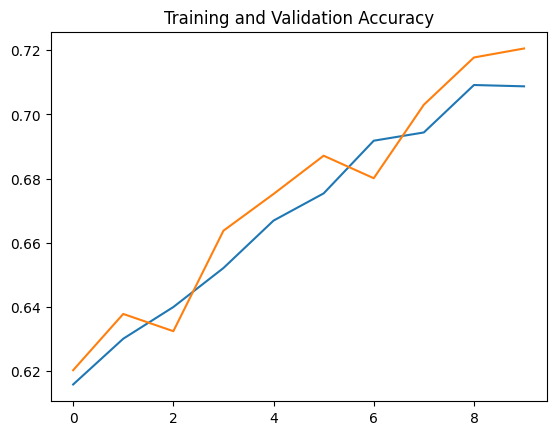

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Training and Validation Accuracy')
plt.xlabel=('Epoch')
plt.ylabel

In [8]:
model.save("cassava_cnn_model.h5")


In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [10]:
def display_gradcam(img_path, model, last_conv_layer_name='conv2d_2'):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


    superimposed_img = heatmap * 0.4 + img_array[0] * 255
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()


In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

# Load base EfficientNetB0 without the top classifier
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom classifier head
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)
model_tf = Model(inputs, outputs)

# Compile
model_tf.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

model_tf.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)